## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## Reading Training Data

In [2]:
file_path = r"C:\Projects\AWS-SageMaker-Flight_Price_Predictor\data\train.csv"

train = pd.read_csv(file_path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-03,Delhi,Cochin,13:15:00,09:25:00,1210,2.0,No Info,10467
1,Jet Airways,2019-05-27,Delhi,Cochin,19:15:00,04:25:00,550,1.0,In-flight meal not included,12898
2,Jet Airways,2019-05-21,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info,14781
3,Jet Airways,2019-05-18,Delhi,Cochin,11:00:00,14:15:00,195,0.0,No Info,9564
4,Air India,2019-05-15,Kolkata,Banglore,14:15:00,16:45:00,150,0.0,No Info,5510


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    col : pd.to_datetime(train.loc[:,col],dayfirst=True,format="mixed")
    for col in ["date_of_journey","dep_time","arrival_time"]
})
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-03,Delhi,Cochin,2024-07-07 13:15:00,2024-07-07 09:25:00,1210,2.0,No Info,10467
1,Jet Airways,2019-05-27,Delhi,Cochin,2024-07-07 19:15:00,2024-07-07 04:25:00,550,1.0,In-flight meal not included,12898
2,Jet Airways,2019-05-21,Kolkata,Banglore,2024-07-07 06:30:00,2024-07-07 19:50:00,800,1.0,No Info,14781
3,Jet Airways,2019-05-18,Delhi,Cochin,2024-07-07 11:00:00,2024-07-07 14:15:00,195,0.0,No Info,9564
4,Air India,2019-05-15,Kolkata,Banglore,2024-07-07 14:15:00,2024-07-07 16:45:00,150,0.0,No Info,5510
...,...,...,...,...,...,...,...,...,...,...
6690,Spicejet,2019-06-24,Kolkata,Banglore,2024-07-07 17:10:00,2024-07-07 19:40:00,150,0.0,No Info,3873
6691,Multiple Carriers,2019-06-15,Delhi,Cochin,2024-07-07 10:20:00,2024-07-07 19:15:00,535,1.0,No Info,9526
6692,Indigo,2019-04-21,Delhi,Cochin,2024-07-07 02:00:00,2024-07-07 07:45:00,345,1.0,No Info,6258
6693,Jet Airways,2019-03-24,Kolkata,Banglore,2024-07-07 21:10:00,2024-07-07 08:10:00,660,1.0,In-flight meal not included,11134


## High Level Summary of data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6695 non-null   float64       
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.2+ KB


In [7]:
train.describe(include="number")

,duration,total_stops,price
count,6695.000000,6695.000000,6695.000000
mean,631.109037,0.802390,9047.110829
std,501.727303,0.659055,4565.426652
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5228.000000
50%,505.000000,1.000000,8309.000000
75%,915.000000,1.000000,12351.000000
max,2860.000000,4.000000,57209.000000


In [8]:
(
    train
    .assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6695.0,6695
unique,9,5,6,5.0,9
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2394,2791,2791,3633.0,5216


## Analysing Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## High-level Analysis of Outliers

In [10]:
forest = IsolationForest(n_estimators=10, random_state=9)

In [11]:
(
    train
    .assign(outlier=forest.fit_predict(
        train
        .drop(columns="price")
        .select_dtypes(include="number")
    ))
    .query("outlier == -1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-06-03,Delhi,Cochin,2024-07-07 13:15:00,2024-07-07 09:25:00,1210,2.0,No Info,10467,-1
3,Jet Airways,2019-05-18,Delhi,Cochin,2024-07-07 11:00:00,2024-07-07 14:15:00,195,0.0,No Info,9564,-1
4,Air India,2019-05-15,Kolkata,Banglore,2024-07-07 14:15:00,2024-07-07 16:45:00,150,0.0,No Info,5510,-1
8,Air India,2019-03-06,Banglore,New Delhi,2024-07-07 08:15:00,2024-07-07 22:55:00,880,2.0,No Info,13942,-1
12,Jet Airways,2019-06-15,Delhi,Cochin,2024-07-07 11:45:00,2024-07-07 12:35:00,1490,2.0,No Info,13882,-1
...,...,...,...,...,...,...,...,...,...,...,...
6680,Spicejet,2019-06-01,Kolkata,Banglore,2024-07-07 09:00:00,2024-07-07 11:25:00,145,0.0,No Info,4174,-1
6681,Jet Airways,2019-06-06,Delhi,Cochin,2024-07-07 14:00:00,2024-07-07 19:00:00,300,1.0,No Info,14714,-1
6685,Air India,2019-06-06,Kolkata,Banglore,2024-07-07 05:50:00,2024-07-07 12:30:00,1840,2.0,No Info,12723,-1
6689,Vistara,2019-06-18,Delhi,Cochin,2024-07-07 06:00:00,2024-07-07 09:10:00,190,0.0,No Info,6216,-1


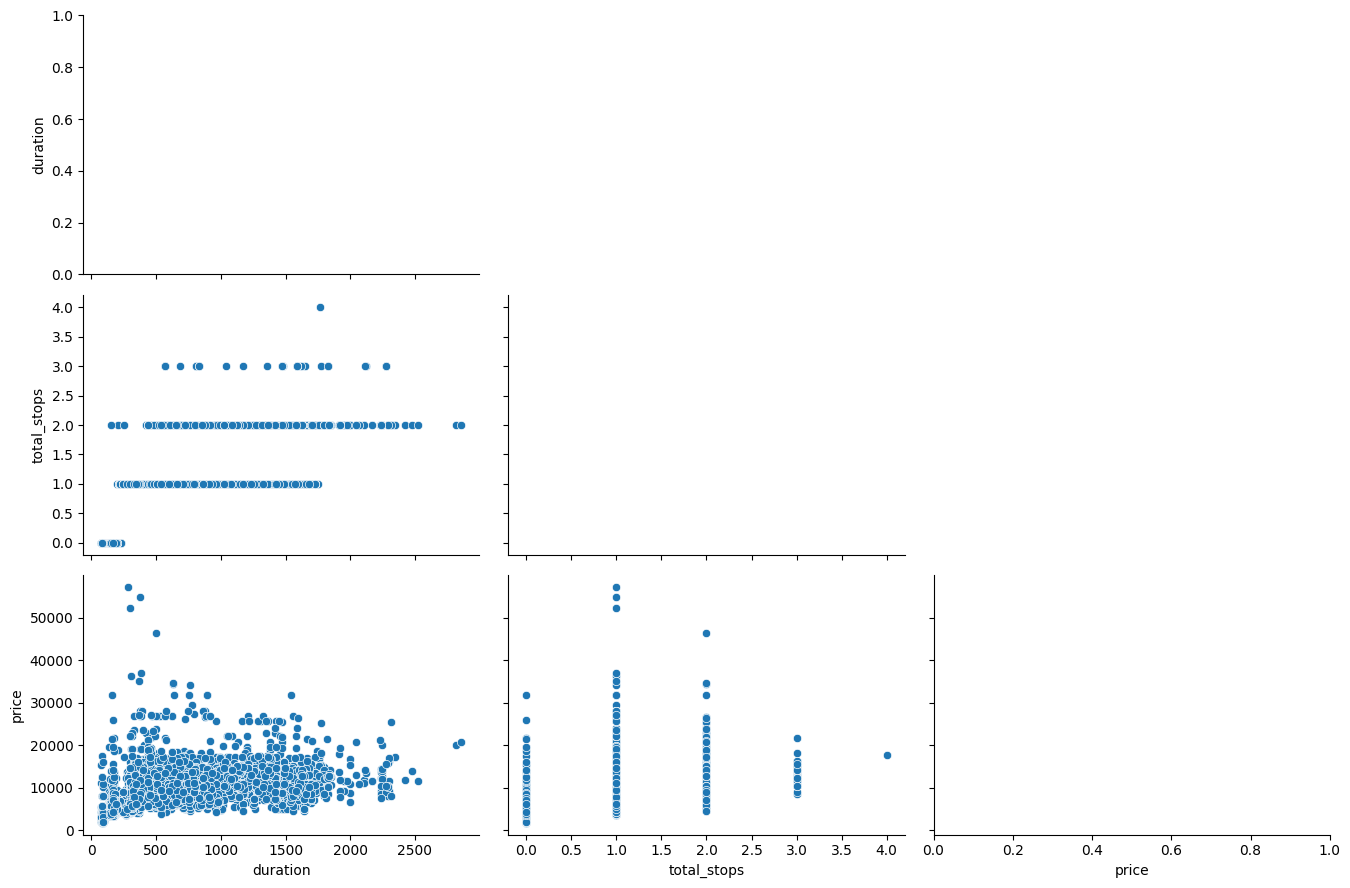

In [12]:
eda_helper_functions.pair_plots(train)

## Correlation Analysis

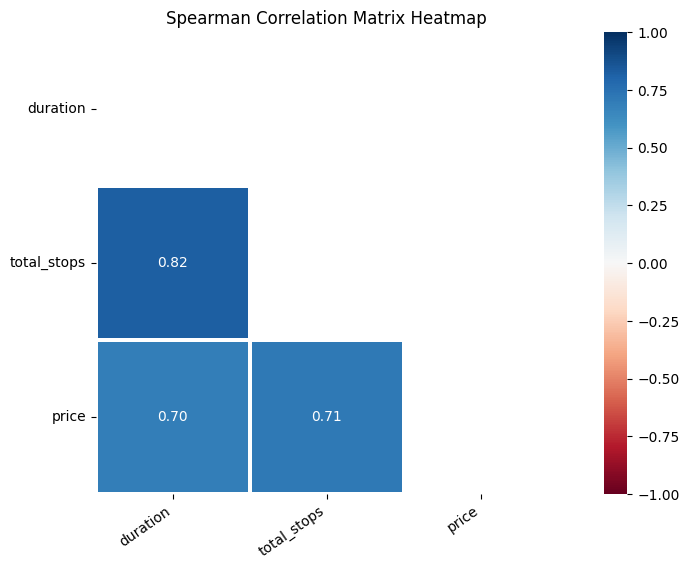

In [13]:
eda_helper_functions.correlation_heatmap(train)

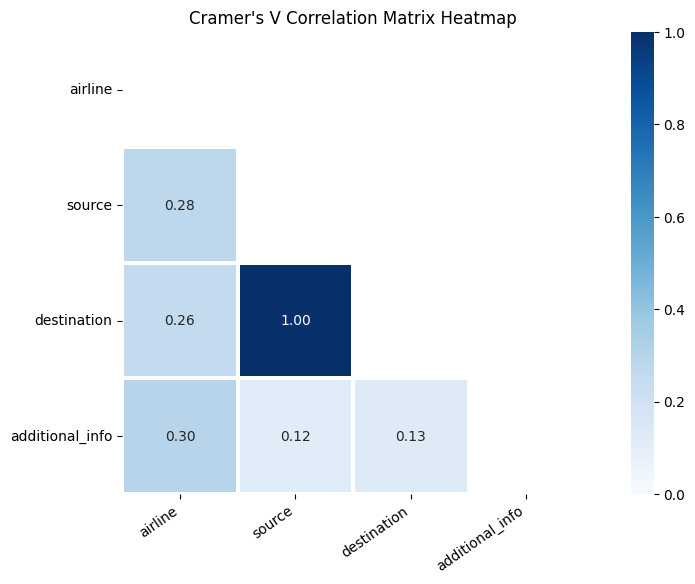

In [14]:
eda_helper_functions.cramersV_heatmap(train)

## Detailed Analysis

In [15]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### Airline

In [16]:
train.airline

0               Air India
1             Jet Airways
2             Jet Airways
3             Jet Airways
4               Air India
              ...        
6690             Spicejet
6691    Multiple Carriers
6692               Indigo
6693          Jet Airways
6694             Spicejet
Name: airline, Length: 6695, dtype: object

In [17]:
eda_helper_functions.cat_summary(train,"airline")

0               Air India
1             Jet Airways
2             Jet Airways
3             Jet Airways
4               Air India
              ...        
6690             Spicejet
6691    Multiple Carriers
6692               Indigo
6693          Jet Airways
6694             Spicejet
Name: airline, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,9
top,Jet Airways
freq,2394


,count,percentage
category,,
Jet Airways,2394,0.357580
Indigo,1295,0.193428
Air India,1061,0.158476
Multiple Carriers,779,0.116355
Spicejet,530,0.079164
Vistara,299,0.044660
Air Asia,219,0.032711
Goair,117,0.017476
Trujet,1,0.000149


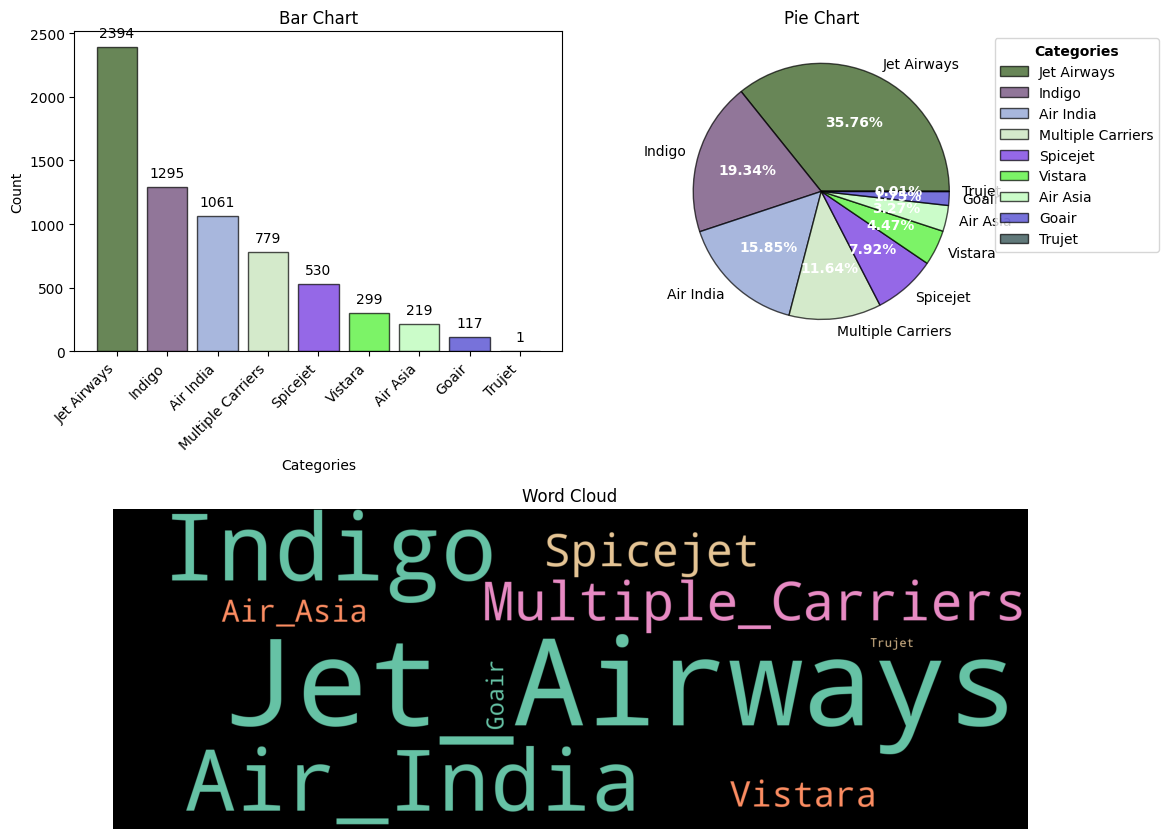

In [18]:
eda_helper_functions.cat_univar_plots(train,"airline")

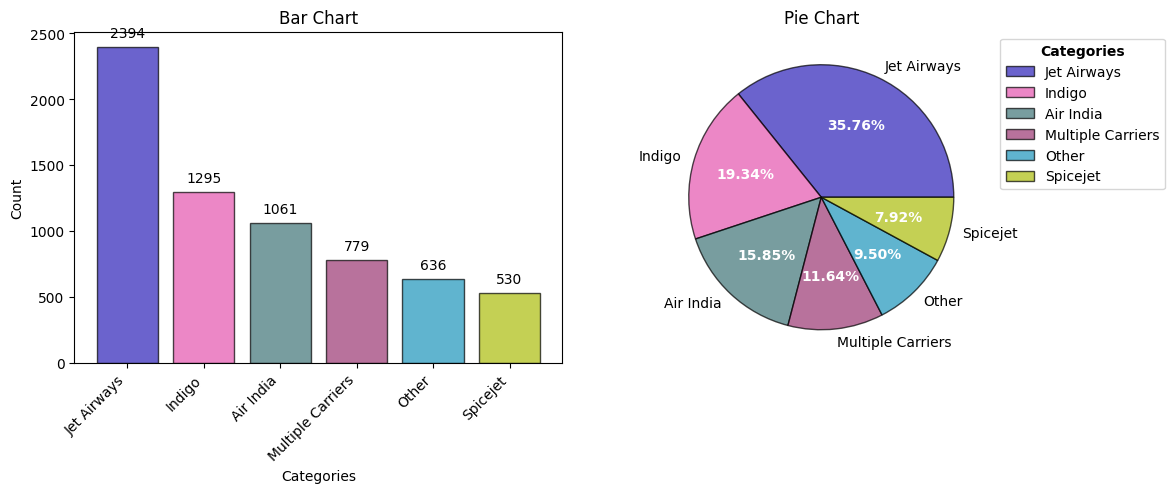

In [19]:
eda_helper_functions.cat_univar_plots(train,"airline",show_wordcloud=False,k=5)

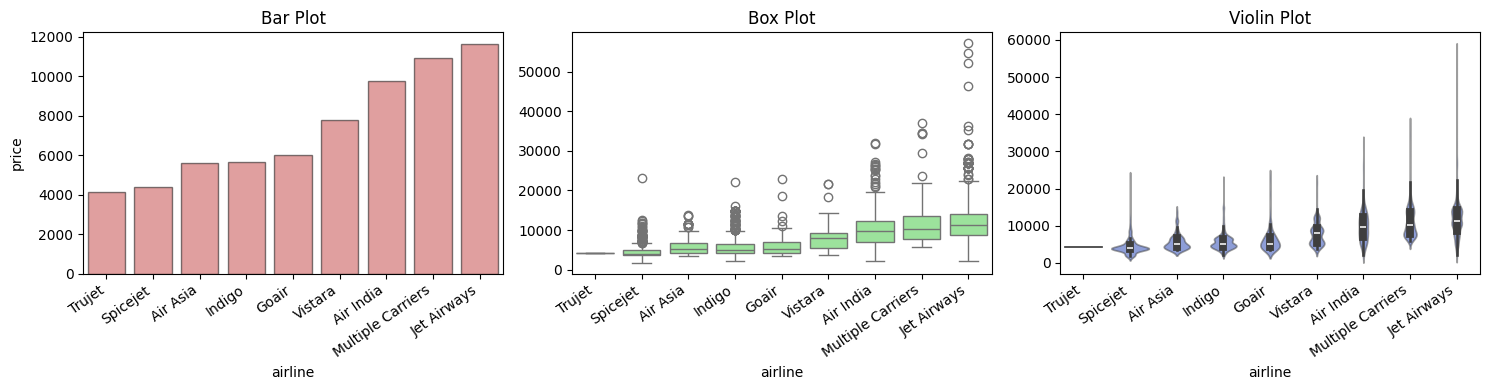

In [20]:
eda_helper_functions.num_cat_bivar_plots(data=train,num_var="price",cat_var="airline")

#### Hypothesis test

In [21]:
eda_helper_functions.num_cat_hyp_testing(data=train,num_var="price",cat_var="airline",alpha=0.05)

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 467.4363615677171
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3049.272692547252
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


#### Multivariate Analysis

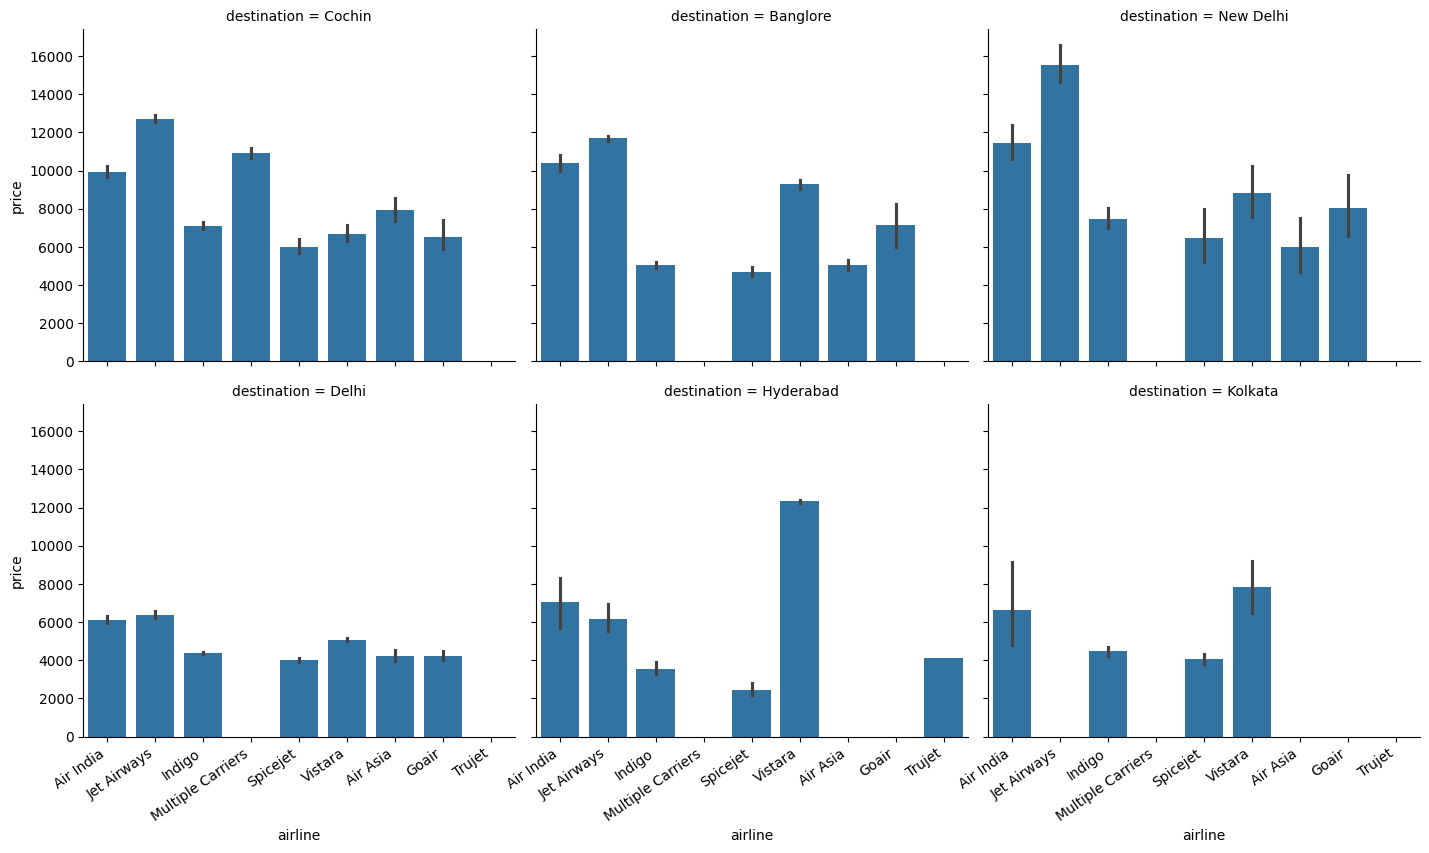

In [22]:
airline_grid = sns.FacetGrid(
    data=train,
    col="destination",
    col_wrap=3,
    height =4,
    aspect=1.2,
    sharey=True
)

airline_grid.map(sns.barplot,"airline","price",order=train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

## markdown notes
based on observation till now

### Date of Journey

In [23]:
train.date_of_journey

0      2019-06-03
1      2019-05-27
2      2019-05-21
3      2019-05-18
4      2019-05-15
          ...    
6690   2019-06-24
6691   2019-06-15
6692   2019-04-21
6693   2019-03-24
6694   2019-03-18
Name: date_of_journey, Length: 6695, dtype: datetime64[ns]

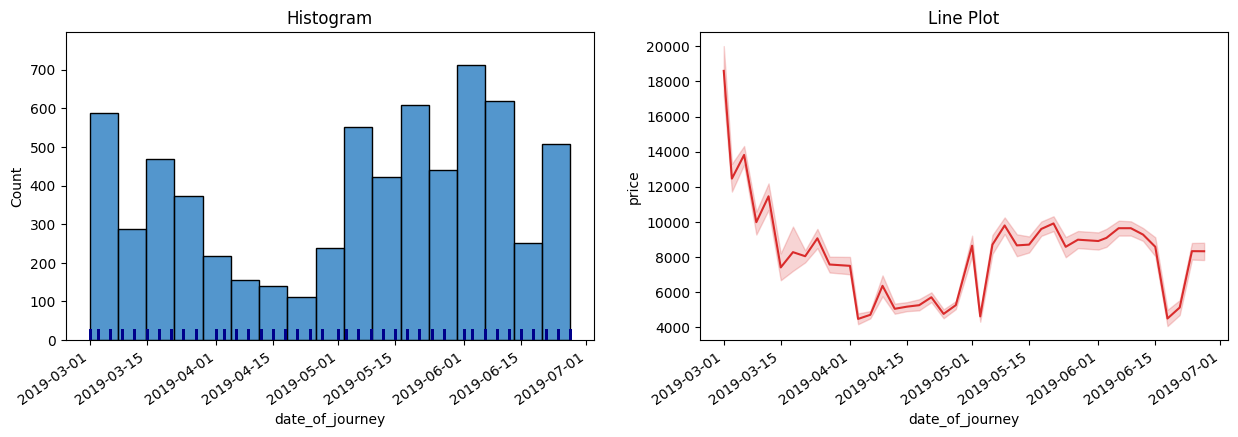

In [24]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

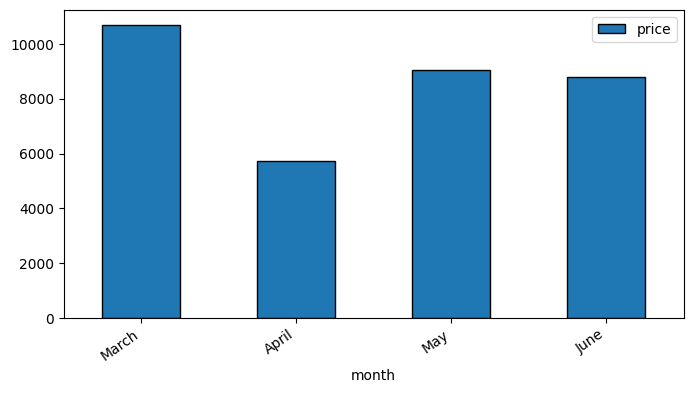

In [25]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="M"))
    .price.mean()
    .to_frame()
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor="black"
    )
)
ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

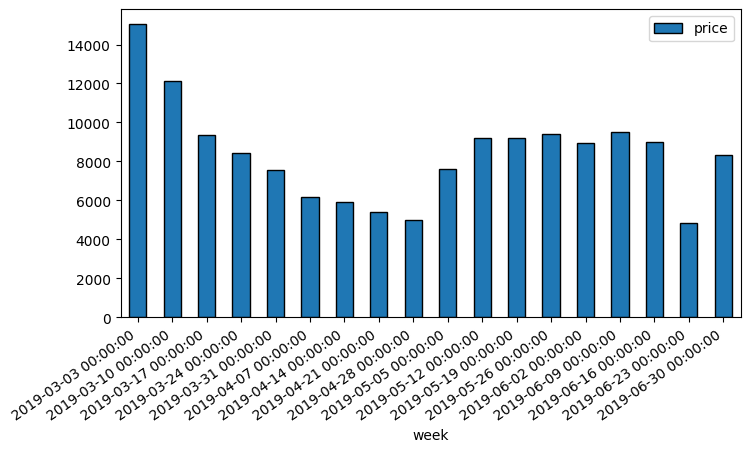

In [26]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="W"))
    .price.mean()
    .to_frame()
    # .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="week")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor="black"
    )
)
ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

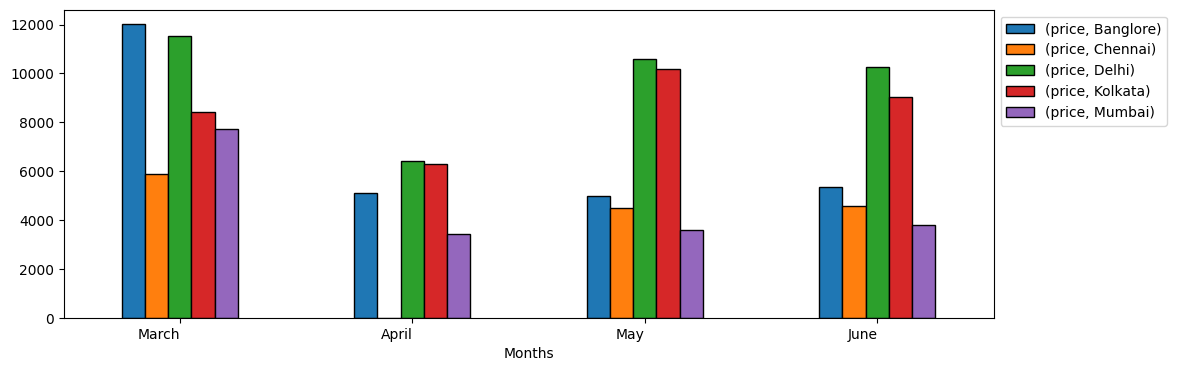

In [27]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey",freq="M"),"source"])
    .price.mean()
    .to_frame()
    .unstack(fill_value=0)
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="Months")
    .plot(
        kind="bar",
        figsize=(12,4),
        edgecolor="black"
    )
)

ax = plt.gca()

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1,1)
)

eda_helper_functions.rotate_xlabels(ax,0)

### dep_time

In [28]:
train.dep_time

0      2024-07-07 13:15:00
1      2024-07-07 19:15:00
2      2024-07-07 06:30:00
3      2024-07-07 11:00:00
4      2024-07-07 14:15:00
               ...        
6690   2024-07-07 17:10:00
6691   2024-07-07 10:20:00
6692   2024-07-07 02:00:00
6693   2024-07-07 21:10:00
6694   2024-07-07 05:45:00
Name: dep_time, Length: 6695, dtype: datetime64[ns]

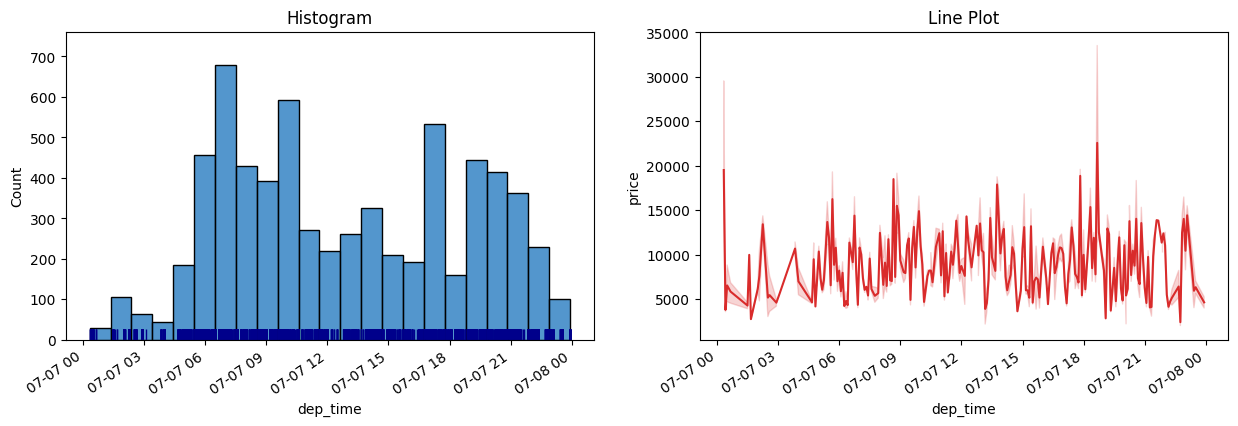

In [29]:
eda_helper_functions.dt_univar_plots(train,"dep_time","price")

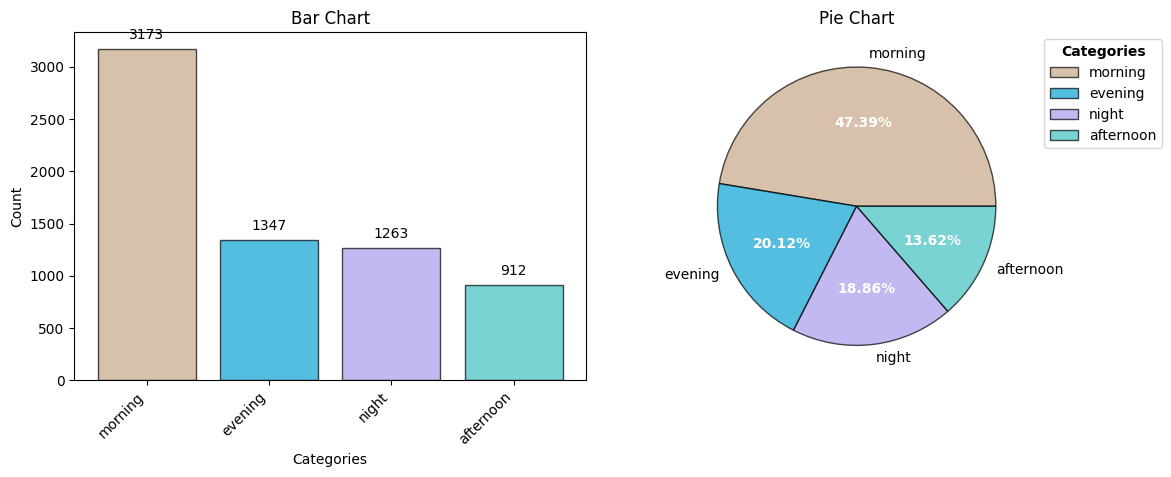

In [30]:
(
    train
    .assign(dep_time= lambda df_: (
        np.select([df_.dep_time.dt.hour.between(4,12, inclusive="left"),
                 df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                 df_.dep_time.dt.hour.between(16,20, inclusive="left")],
                 ["morning","afternoon","evening"],
                default="night")
    ))
    .pipe(eda_helper_functions.cat_univar_plots,"dep_time",show_wordcloud=False)
)

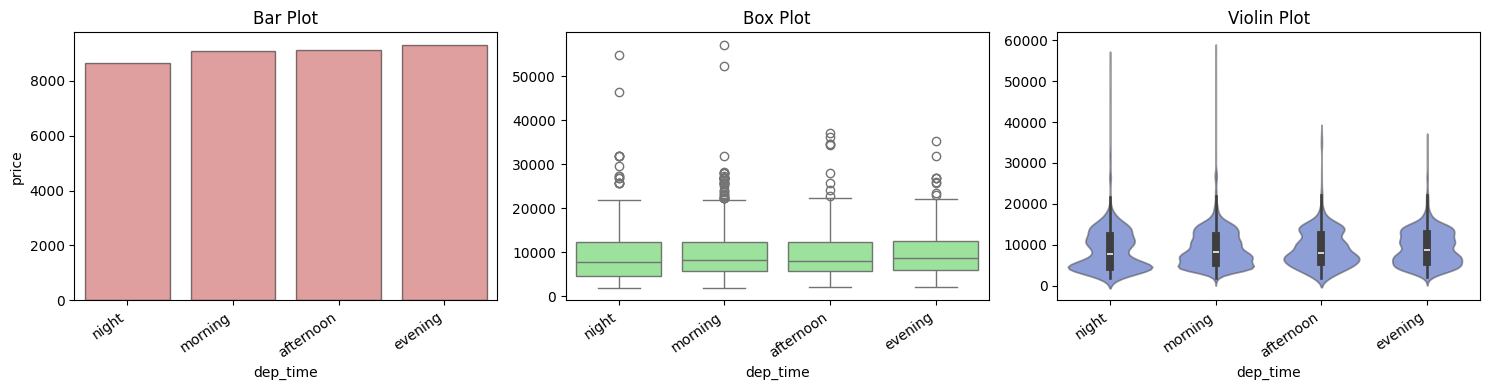

In [31]:
(
    train
    .assign(dep_time= lambda df_: (
        np.select([df_.dep_time.dt.hour.between(4,12, inclusive="left"),
                 df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                 df_.dep_time.dt.hour.between(16,20, inclusive="left")],
                 ["morning","afternoon","evening"],
                default="night")
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,"price","dep_time")
)

### duration

In [32]:
train.duration

0       1210
1        550
2        800
3        195
4        150
        ... 
6690     150
6691     535
6692     345
6693     660
6694     170
Name: duration, Length: 6695, dtype: int64

In [33]:
eda_helper_functions.num_summary(train,"duration")

0       1210
1        550
2        800
3        195
4        150
        ... 
6690     150
6691     535
6692     345
6693     660
6694     170
Name: duration, Length: 6695, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,505.0
75,915.0
90,1440.0
95,1610.0
99,1840.0


,value
mean,631.109037
trimmed mean (5%),597.307948
trimmed mean (10%),568.255553
median,505.000000


,value
var,251730.286884
std,501.727303
IQR,745.000000
mad,335.000000
coef_variance,0.794993


,value
skewness,0.907437
kurtosis,-0.030347


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 4.550329012212285e-57
Test Statistic       : 0.8852534522270592
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 251.5480282166709
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


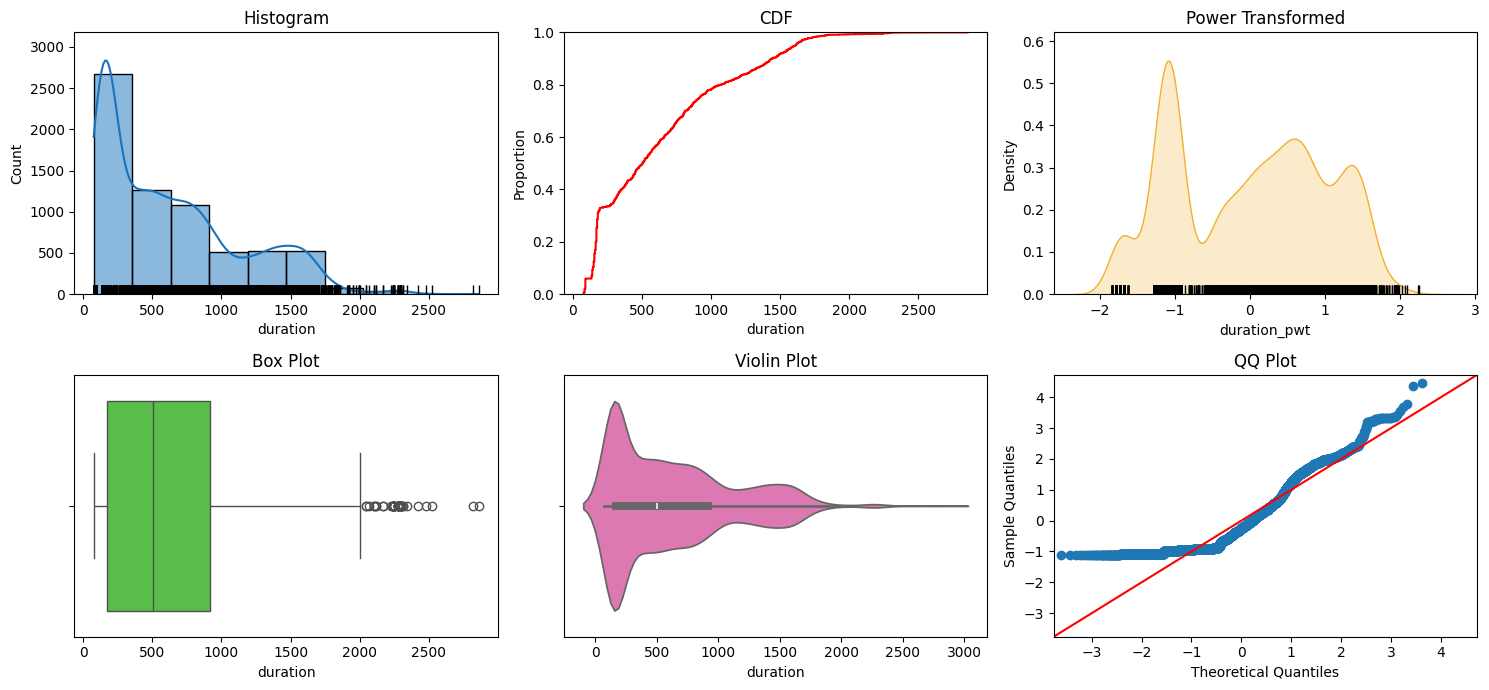

In [34]:
eda_helper_functions.num_univar_plots(train,"duration")

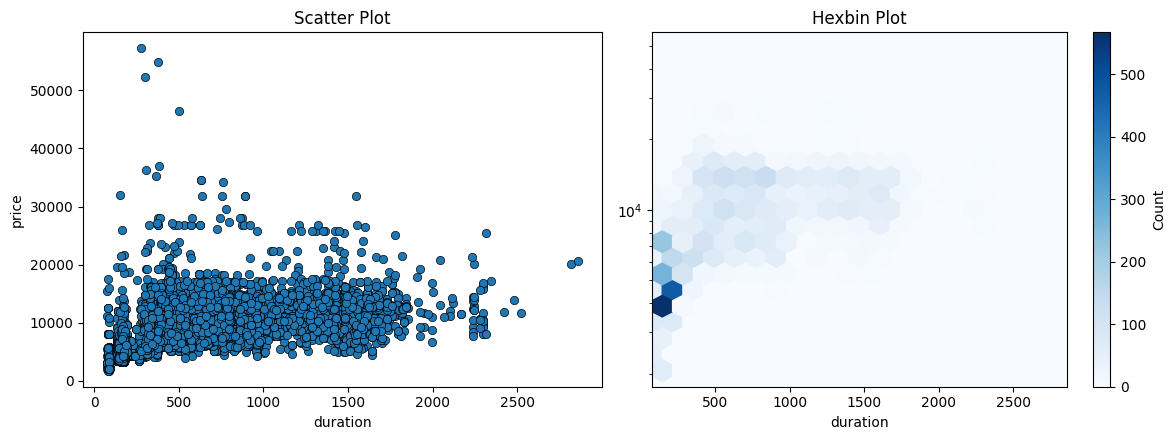

In [35]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=20,
        cmap="Blues"
    )
)

In [36]:
eda_helper_functions.num_num_hyp_testing(train,"price","duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5167456846518466
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6951386174941204
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


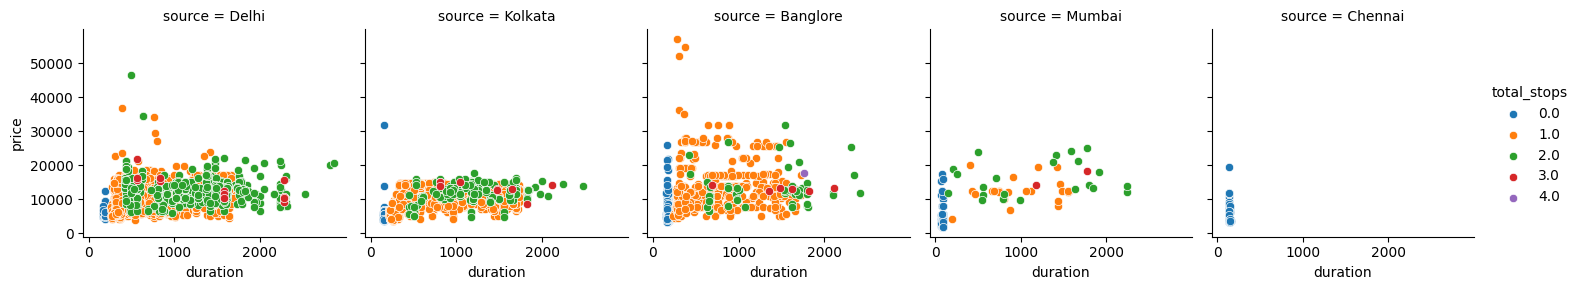

In [37]:
duration_grid = sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops", # 4th dimention
    sharey=True
)

duration_grid.map(sns.scatterplot,"duration","price")
duration_grid.add_legend()

In [38]:
from ydata_profiling import ProfileReport

In [39]:
report = ProfileReport(train)

In [40]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
report.to_file(output_file="eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]